In [1]:
# import pakietów
import pandas as pd
import urllib
from IPython.display import HTML
from urllib.request import urlopen
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import re
from statistics import mean

In [2]:
#import danych
col_names = ['ID', 'gender', 'city', 'income', 'birth_date', 'application_date', 'requested_amount', 
             'requested_period', 'financial_obligations', 'employer_name', 'account_bank', 'mobile_verification_flag',
             'var_5', 'var_1', 'offer_amount', 'offer_period', 'interest_rate', 'fee', 'offer_monthly_obligation',
             'filled_form_flag', 'device', 'var_2', 'source', 'var_4', 'logged_in_flag', 'disbursed_flag']
dataset = pd.read_csv('C:/Users/Ja/Desktop/projekt zaliczeniowy/dane/train.csv', delimiter = ',', dtype='str', 
                      header = None, names = col_names, engine='python', index_col = False, skiprows = 1 )

HTML(dataset.head().to_html())

,ID,gender,city,income,birth_date,application_date,requested_amount,requested_period,financial_obligations,employer_name,account_bank,mobile_verification_flag,var_5,var_1,offer_amount,offer_period,interest_rate,fee,offer_monthly_obligation,filled_form_flag,device,var_2,source,var_4,logged_in_flag,disbursed_flag
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000,5,0,CYBOSOL,HDFC Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000,2,0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000,2,13.25,nan,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000,4,0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000,4,nan,nan,nan,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000,5,0,BIHAR GOVERNMENT,State Bank of India,Y,10,HBXX,920000,5,nan,nan,nan,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000,2,25000,GLOBAL EDGE SOFTWARE,HDFC Bank,Y,17,HBXX,500000,2,nan,nan,nan,N,Web-browser,B,S134,3,1,0


In [3]:
months_dict = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06',
               'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

# TO DO - opis funckji i testy jednostkowe
def date_transform(date:str, twentieth_cent=False):
    day = date[:2]
    month = months_dict[date[3:6]]
    if twentieth_cent:
        return '19' + date[-2:] + "-" + month + "-" + day
    else:
        return '20' + date[-2:] + "-" + month + "-" + day

# formatowanie danych
dataset['income'] = dataset['income'].astype(float)
dataset['birth_date'] = dataset.apply(lambda x: date_transform(x['birth_date'], True), axis=1)
dataset['application_date'] = dataset.apply(lambda x: date_transform(x['application_date']), axis=1)
dataset['requested_amount'] = dataset['requested_amount'].astype(float)
dataset['financial_obligations'] = dataset['financial_obligations'].astype(float)

HTML(dataset.head().to_html())

,ID,gender,city,income,birth_date,application_date,requested_amount,requested_period,financial_obligations,employer_name,account_bank,mobile_verification_flag,var_5,var_1,offer_amount,offer_period,interest_rate,fee,offer_monthly_obligation,filled_form_flag,device,var_2,source,var_4,logged_in_flag,disbursed_flag
0,ID000002C20,Female,Delhi,20000.0,1978-05-23,2015-05-15,300000.0,5,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000.0,1985-10-07,2015-05-04,200000.0,2,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000,2,13.25,nan,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500.0,1981-10-10,2015-05-19,600000.0,4,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000,4,nan,nan,nan,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000.0,1987-11-30,2015-05-09,1000000.0,5,0.0,BIHAR GOVERNMENT,State Bank of India,Y,10,HBXX,920000,5,nan,nan,nan,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000.0,1984-02-17,2015-05-20,500000.0,2,25000.0,GLOBAL EDGE SOFTWARE,HDFC Bank,Y,17,HBXX,500000,2,nan,nan,nan,N,Web-browser,B,S134,3,1,0


In [4]:
# gps coordinates of cities from Internet
cities = set(dataset['city'])
min_latitude = 7
max_latitude = 38
min_longitude = 67
max_longitude = 98

def get_coords_from_pattern(string, pattern):
    coords = string.split(" ")
    degs = float(coords[0].split(pattern[6])[0])
    mins = float(coords[1].split(pattern[16])[0])
    secs = float(coords[2].split(pattern[33])[0])
    return degs + mins/60.0 + secs/3600.0


def convert_list_to_coord(found, pattern):
    n, e = None, None
    found_n, found_e = [], []
    # wiki pattern
    if 'nsew' not in pattern:
        found_n = [float(item.split(" ")[0].split('°')[0]) for item in found]
        found_e = [float(item.split(" ")[1].split('°')[0]) for item in found]
    # google patterns
    else:
        found_n = [get_coords_from_pattern(item, pattern) for item in found if item[-1]=='n']
        found_e = [get_coords_from_pattern(item, pattern) for item in found if item[-1]=='e']
        found_n = [coord for coord in found_n if coord >= min_latitude and coord <= max_latitude]
        found_e = [coord for coord in found_e if coord >= min_longitude and coord <= max_longitude]
    if found_n:
        n = mean(found_n)
    if found_e:
        e = mean(found_e)               
    return [n, e]


# 1 - data directly from Wikipedia
def get_wikipedia_data(city):
    pattern = "[0-9]+.[0-9]+°n [0-9]+.[0-9]+°e"
    found = []
    try:
        with urlopen("https://en.wikipedia.org/wiki/" + city) as page:
            soup = BeautifulSoup(page.read(), "html.parser")
            response_list = soup.select(".geo-dec")            
            for item in response_list:
                found += re.findall(pattern, item.get_text().lower())
    except urllib.request.HTTPError:
        pass
    return convert_list_to_coord(found, pattern)


# 2 - data from google search results   
def get_google_search_data(city):
    pattern = "[0-9]+°[ ][0-9]+'[ ][0-9]+.[0-9]+''[ ][nsew]"
    found = []        
    driver.get('https://www.google.pl/search?q=' + city + '+latitude+and+longitude+in+decimal')
    found = re.findall(pattern, driver.page_source.lower())
    return convert_list_to_coord(found, pattern)


def get_latitude_to_data(city):
    pattern = "[0-9]+°[ ][0-9]+'[ ][0-9]+.[0-9]+\"[ ][nsew]"
    found = []        
    driver.get('https://www.google.pl/search?q=' + city + '+india+gps+coords')
    try:
        links = driver.find_elements_by_css_selector('.rc')
        links = [item for item in links if 'latitude.to' in item.text.lower()]
        if links:
            links[0].find_element_by_css_selector('h3').click()
            undone = True
            while undone:
                if 'google' not in driver.current_url:
                    try:
                        found = re.findall(pattern, driver.page_source.lower())
                    except NoSuchElementException:
                        pass                        
                    undone = False
    except NoSuchElementException:
        pass
    return convert_list_to_coord(found, pattern)

In [5]:
# driver = webdriver.Chrome('chromedriver')

# coords = {}
# for item in list(cities)[:]:
#     coords[item] = get_wikipedia_data(item)
#     if coords[item][0] == None or coords[item][1] == None:
#         coords[item] = get_google_search_data(item)
#     if coords[item][0] == None or coords[item][1] == None:
#         coords[item] = get_latitude_to_data(item)   
# driver.close()

# cities_coords = pd.DataFrame.from_dict(coords, orient='index', columns = ['city', 'coords'])
# cities_coords.to_csv('C:/Users/Ja/Desktop/projekt zaliczeniowy/co.csv')
cities_coords = pd.read_csv('C:/Users/Ja/Desktop/projekt zaliczeniowy/co.csv', names = ['city', 'latitude', 'longitude'], skiprows = 1)
cities_coords = cities_coords[~pd.isnull(cities_coords['latitude'])]

In [6]:
#coordinates
dataset2 = pd.merge(dataset, cities_coords, on = 'city')
dataset2 = dataset2.drop(columns = ['logged_in_flag', 'city'], axis = 1)
HTML(dataset2.head().to_html())

,ID,gender,income,birth_date,application_date,requested_amount,requested_period,financial_obligations,employer_name,account_bank,mobile_verification_flag,var_5,var_1,offer_amount,offer_period,interest_rate,fee,offer_monthly_obligation,filled_form_flag,device,var_2,source,var_4,disbursed_flag,latitude,longitude
0,ID000002C20,Female,20000.0,1978-05-23,2015-05-15,300000.0,5,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Web-browser,G,S122,1,0,28.61,77.23
1,ID000025Z00,Female,20000.0,1990-01-06,2015-05-01,100000.0,5,0.0,INTEC CAPITAL LTD,HDFC Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Web-browser,B,S122,1,0,28.61,77.23
2,ID000040O00,Female,2900.0,1982-07-22,2015-05-01,0.0,0,0.0,INVENTIV INTERNATIONAL PHARMA SERVICES P LTD,Standard Chartered Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Mobile,C,S133,1,0,28.61,77.23
3,ID000044S40,Female,75000.0,1988-04-27,2015-05-01,0.0,0,0.0,INTERGLOBE AVIATION LTD (INDIGO),HDFC Bank,Y,8,HBXC,980000,3,15.5,9800,34212.47,Y,Mobile,C,S133,5,0,28.61,77.23
4,ID000056E10,Male,20000.0,1990-03-28,2015-05-01,0.0,0,0.0,JUST DIAL,Central Bank of India,Y,3,HBXX,290000,5,nan,nan,nan,N,Mobile,C,S133,3,0,28.61,77.23


In [7]:
def count_age(birth_date, application_date):
    out = int(application_date[:4]) - int(birth_date[:4])
    out += (int(application_date[5:7]) - int(birth_date[5:7]))/12.0
    out += (int(application_date[8:10]) - int(birth_date[8:10]))/365.25
    return round(out, 2)

dataset2['age'] = dataset2.apply(lambda x: count_age(x['birth_date'], x['application_date']), axis = 1)
dataset2 = dataset2.drop(columns = ['birth_date', 'application_date'])

In [24]:
HTML(dataset2.head().to_html())

,ID,gender,income,requested_amount,requested_period,financial_obligations,employer_name,account_bank,mobile_verification_flag,var_5,var_1,offer_amount,offer_period,interest_rate,fee,offer_monthly_obligation,filled_form_flag,device,var_2,source,var_4,disbursed_flag,latitude,longitude,age
0,ID000002C20,Female,20000.0,300000.0,5,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Web-browser,G,S122,1,0,28.61,77.23,36.98
1,ID000025Z00,Female,20000.0,100000.0,5,0.0,INTEC CAPITAL LTD,HDFC Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Web-browser,B,S122,1,0,28.61,77.23,25.32
2,ID000040O00,Female,2900.0,0.0,0,0.0,INVENTIV INTERNATIONAL PHARMA SERVICES P LTD,Standard Chartered Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Mobile,C,S133,1,0,28.61,77.23,32.78
3,ID000044S40,Female,75000.0,0.0,0,0.0,INTERGLOBE AVIATION LTD (INDIGO),HDFC Bank,Y,8,HBXC,980000,3,15.5,9800,34212.47,Y,Mobile,C,S133,5,0,28.61,77.23,27.01
4,ID000056E10,Male,20000.0,0.0,0,0.0,JUST DIAL,Central Bank of India,Y,3,HBXX,290000,5,nan,nan,nan,N,Mobile,C,S133,3,0,28.61,77.23,25.09


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import statistics as stat

columns_for_logistic_regression = ['income',  'age']
X = dataset2[columns_for_logistic_regression]
y = dataset2['disbursed_flag']

log_C = 1
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.30)
log_reg = LogisticRegression(C=10**log_C, random_state=42, solver = 'lbfgs')
log_reg.fit(X_train, y_train)
train = accuracy_score(log_reg.predict(X_train),y_train)
test = accuracy_score(log_reg.predict(X_test),y_test)
print("train: " + str(train) + ' test: ' + str(test) )



train: 0.9850255114760093 test: 0.9856522413525671


AttributeError: Unknown property size

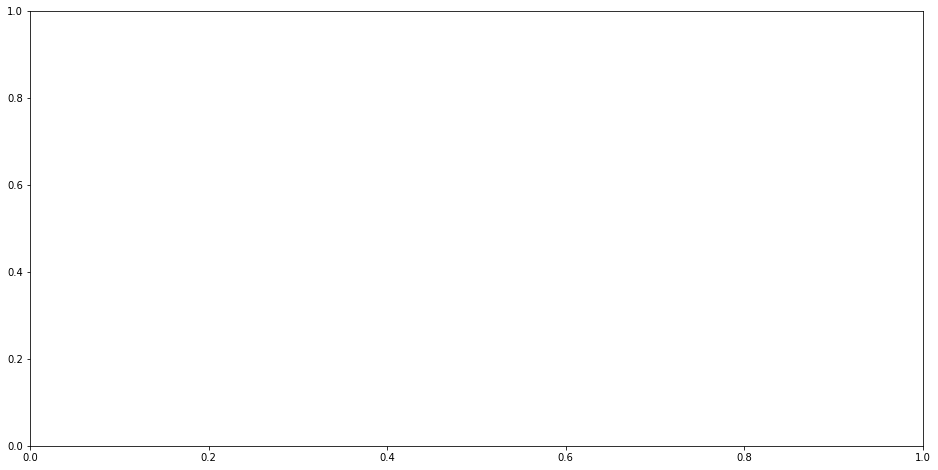

In [49]:
income = X['income']
age = X['age']

plt.figure(figsize=(16, 8))
plt.scatter(income, age, c=y, size = 1)
plt.axis([0, 10e7, 15, 90])
plt.show()